In [ ]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f'GPUs Available: {len(physical_devices)}')
if physical_devices: tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available: 1


# Set parameters

In [ ]:
N_POINTS= 25
N_CLASSES = 1
SAMPLES_PER_MESH = 50
BATCH_SIZE = 32

# Dataset download

In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://modelnet.cs.princeton.edu/ModelNet40.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet40")

# Parse dataset
* **Data Parser:** Each mesh is loaded ans sampled into a point cloud and is returned as a numpy array

In [ ]:
def objectPerspective(points, centroid, angle, n=100):
    if not (-np.pi < angle < np.pi):
        raise ValueError('Angle must be between -pi and pi')

    complexes = np.empty(len(points), dtype=np.complex64)
    complexes.real = points[:,0] - centroid[0]
    complexes.imag = points[:,1] - centroid[1]
    subset = points[np.angle(complexes) <= angle]

    if subset.shape[0] > 0:
        return subset[np.random.choice(subset.shape[0], n, replace=(subset.shape[0] < n)), :]
    else:
        return points[np.random.choice(points.shape[0], n, replace=(points.shape[0] < n)), :]

def meshMultisample(mesh, num_points, n):
    samples = []
    centroid = mesh.centroid
    for i in range(n):
        samples.append(objectPerspective(mesh.sample(2048), centroid, np.random.uniform(-np.pi/2, np.pi), num_points))

    return samples

def nRandomNoConeSamples(n, mode, num_points):
    """ mode = [train|test]"""
    points = []
    labels = []
    files = list(set(glob.glob(os.path.join(DATA_DIR, f"[!README]*/{mode}/*"))) - set(glob.glob(os.path.join(DATA_DIR, f"cone/{mode}/*"))))
    
    for i in range(n):
        # gather all files
        f = np.random.choice(files, replace=False)

        mesh = trimesh.load(f)
        centroid = mesh.centroid
        points.append(objectPerspective(mesh.sample(2048), centroid, np.random.uniform(-np.pi/2, np.pi), num_points))
        labels.append(0)

    return points, labels

def parse_dataset(num_points=N_POINTS, samples=SAMPLES_PER_MESH):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    # store cone label name with value so we can retrieve later
    class_map = {
        0: 'no-cone',
        1: 'cone'
    }

    cone_folder = os.path.join(DATA_DIR, 'cone/')

    # gather all files
    train_files = glob.glob(os.path.join(cone_folder, 'train/*'))
    test_files = glob.glob(os.path.join(cone_folder, 'test/*'))


    print('(1/4)\t\tprocessing class cone train\t\t', end='')
    for f in train_files:
        train_points.extend(meshMultisample(trimesh.load(f), num_points, samples))
        train_labels += [1] * samples

    cone_train_cardinality = len(train_labels)
    print(f'{cone_train_cardinality} cones')

    print('(2/4)\t\tprocessing class cone test\t\t', end='')
    for f in test_files:
        test_points.extend(meshMultisample(trimesh.load(f), num_points, 1))
        test_labels.append(1)

    cone_test_cardinality = len(test_labels)
    print(f'{cone_test_cardinality} cones')

    print('(3/4)\t\tprocessing class no-cone train\t\t', end='')
    points, labels = nRandomNoConeSamples(cone_train_cardinality, mode='train', num_points=num_points)
    train_points.extend(points)
    train_labels.extend(labels)

    print(f'{len(labels)} no-cones')
    print('(4/4)\t\tprocessing class no-cone test\t\t', end='')
    points, labels = nRandomNoConeSamples(cone_test_cardinality, mode='test', num_points=num_points)
    test_points.extend(points)
    test_labels.extend(labels)

    print(f'{len(labels)} no-cones')
    return (
        np.array(train_points),
        np.array(train_labels),
        np.array(test_points),
        np.array(test_labels),
        class_map
    )


In [ ]:
train_points, train_labels, test_points, test_labels, CLASS_MAP = parse_dataset(N_POINTS)

(1/4)		processing class cone train		8350 cones
(2/4)		processing class cone test		20 cones
(3/4)		processing class no-cone train		8350 no-cones
(4/4)		processing class no-cone test		20 no-cones


In [ ]:
print(len(train_labels))
print(f'training: The number of cone and no-cone samples is{"" if sum(train_labels) == len(train_labels)/2 else " not"} equal')
print(len(test_labels))
print(f'testing: The number of cone and no-cone samples is{"" if sum(test_labels) == len(test_labels)/2 else " not"} equal')

16700
training: The number of cone and no-cone samples is equal
40
testing: The number of cone and no-cone samples is equal


# Data augmentation

In [ ]:
def augment(points, label):
  # jitter points
  points += tf.random.uniform(points.shape, -0.05, 0.05, dtype=tf.float64)
  # shuffle points
  points = tf.random.shuffle(points)
  return points, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

# Model Building

In [ ]:
def conv_bn(x, filters):
  x = layers.Conv1D(filters, kernel_size=1, padding='valid')(x)
  x = layers.BatchNormalization(momentum=0.0)(x)
  return layers.Activation('relu')(x)

def dense_bn(x, filters):
  x = layers.Dense(filters)(x)
  x = layers.BatchNormalization(momentum=0.0)(x)
  return layers.Activation('relu')(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
  def __init__(self, num_features, l2reg=0.001):
    self.num_features = num_features
    self.l2reg = l2reg
    self.eye = tf.eye(num_features)

  def __call__(self, x):
    x = tf.reshape(x, (-1, self.num_features, self.num_features))
    xxt = tf.tensordot(x, x, axes=(2,2))
    xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
    return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

## T-net layers

In [ ]:
def tnet(inputs, num_features):
  # initialize bias as the identity matrix
  bias = keras.initializers.Constant(np.eye(num_features).flatten())
  reg = OrthogonalRegularizer(num_features)

  x = conv_bn(inputs, 32)
  x = conv_bn(x, 64)
  x = conv_bn(x, 512)
  x = layers.GlobalMaxPooling1D()(x)
  x = dense_bn(x, 256)
  x = dense_bn(x, 128)
  x = layers.Dense(
      num_features * num_features,
      kernel_initializer='zeros',
      bias_initializer=bias,
      activity_regularizer=reg
  )(x)
  feat_T = layers.Reshape((num_features, num_features))(x)
  # Apply affine transformation to input features
  return layers.Dot(axes=(2, 1))([inputs, feat_T])

## CNN

In [ ]:
inputs = keras.Input(shape=(N_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(N_CLASSES, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='pointnet')
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 25, 32)       128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 25, 32)      128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 25, 32)       0           ['batch_normalization[0][0

## Compile and train

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.fit(train_dataset, epochs=15, validation_data=test_dataset)

Epoch 1/15
522/522 [==============================] - 25s 22ms/step - loss: 1.8751 - accuracy: 0.5426 - val_loss: 76395.4531 - val_accuracy: 0.6000
Epoch 2/15
522/522 [==============================] - 12s 22ms/step - loss: 1.8043 - accuracy: 0.5676 - val_loss: 497097441280.0000 - val_accuracy: 0.7250
Epoch 3/15
522/522 [==============================] - 11s 20ms/step - loss: 1.7618 - accuracy: 0.6082 - val_loss: 388365852783337401814948620795904.0000 - val_accuracy: 0.5000
Epoch 4/15
522/522 [==============================] - 10s 20ms/step - loss: 1.7190 - accuracy: 0.6380 - val_loss: 1.5502 - val_accuracy: 0.6750
Epoch 5/15
522/522 [==============================] - 10s 20ms/step - loss: 1.6836 - accuracy: 0.6457 - val_loss: 5756.5342 - val_accuracy: 0.7500
Epoch 6/15
522/522 [==============================] - 11s 22ms/step - loss: 1.6815 - accuracy: 0.6493 - val_loss: 1.6112 - val_accuracy: 0.5000
Epoch 7/15
522/522 [==============================] - 11s 20ms/step - loss: 1.6743 - a

# Results

1/1 [==============================] - 0s 499ms/step


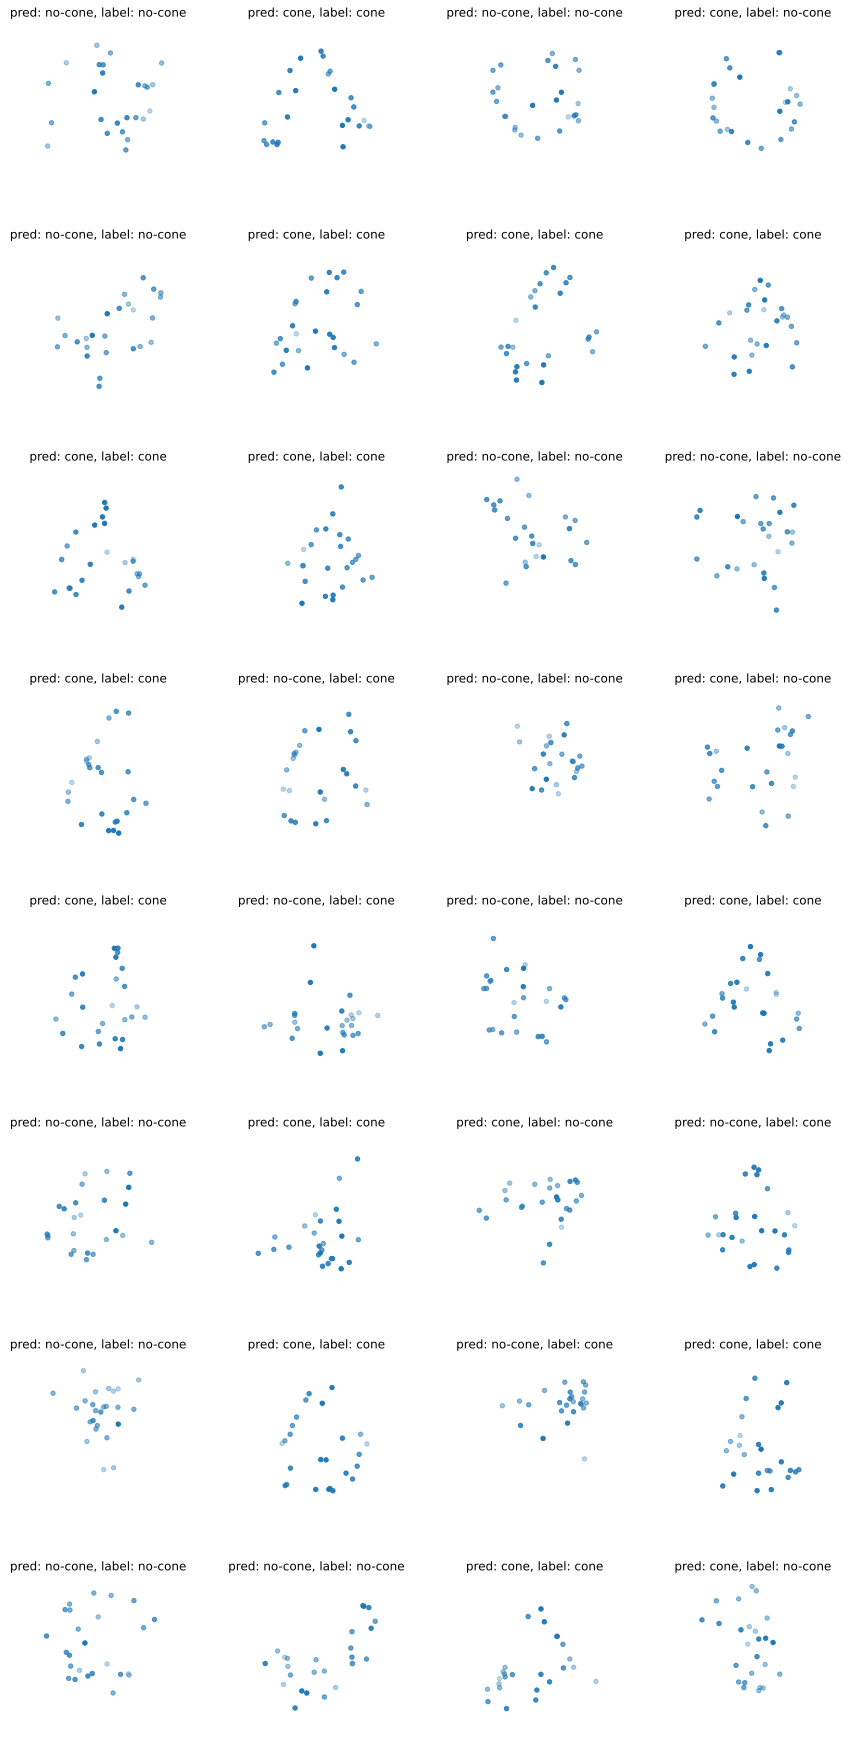

In [ ]:
N_TESTS = 32
THRESHOLD = .5

data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:N_TESTS, ...]
labels = labels[:N_TESTS, ...]

# run test data through model
preds = model.predict(points)
preds = [int(pred > THRESHOLD) for pred in preds]
points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 4*np.ceil(N_TESTS/4)))
for i in range(N_TESTS):
  ax = fig.add_subplot(np.ceil(N_TESTS/4), 4, i + 1, projection='3d')
  ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
  ax.set_title(
      f'pred: {CLASS_MAP[preds[i]]}, label: {CLASS_MAP[labels.numpy()[i]]}'
  )
  ax.set_axis_off()
plt.show()